In [1]:
# Importa las librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

In [2]:
# Descar el dataset Fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
subset_size = 10000  # Número de imágenes a usar
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Tomamos solo las primeras 'subset_size' imágenes
train_images, train_labels = train_images[:subset_size], train_labels[:subset_size]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Verificar que las imágenes se han extraido correctamente
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(10000, 28, 28)
(10000,)
(10000, 28, 28)
(10000,)


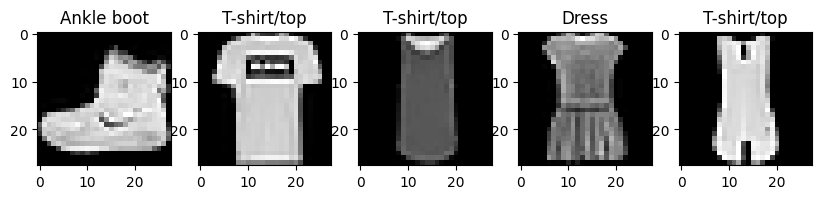

In [4]:
# Carga y muestra algunas imágenes del dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_images = 5
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(class_names[train_labels[i]])



In [5]:
# Carga y procesa el dataset

# Parámetros del dataset y del modelo
img_width = 28
img_height = 28
batch_size = 32
num_classes = 10
epochs = 10

# Procesa las imágenes del dataset
train_images = train_images.reshape(train_images.shape[0], img_width, img_height, 1)
train_images = (train_images - 127.5) / 127.5
test_images = test_images.reshape(test_images.shape[0], img_width, img_height, 1)

In [6]:
# Verifica la estructura del dataset
print(train_images.shape)
print(test_images.shape)

(10000, 28, 28, 1)
(10000, 28, 28, 1)


In [7]:
# Define el generador
LATENT_DIM = 100

generator = keras.Sequential([
    # Copia densa inicial
    layers.Dense(7 * 7 * 256, input_shape=(LATENT_DIM,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Rendimensión a las capas iniciales
    layers.Reshape((7, 7, 256)),

    # Segunda capa de convolución
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Tercera capa de convolución
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Capa final de ajuste a 89x109x3
    layers.Conv2D(3, (3, 3), activation="tanh")

])

generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 3)           │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,343,619 (8.94 MB)

 Trainable params: 2,318,147 (8.84 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [8]:
noise = tf.random.normal([1, LATENT_DIM])
x = noise
for layer in generator.layers:
  x = layer(x)
  print(layer.__class__.__name__ + ": ", x.shape)

Dense:  (1, 12544)
BatchNormalization:  (1, 12544)
LeakyReLU:  (1, 12544)
Reshape:  (1, 7, 7, 256)
Conv2DTranspose:  (1, 14, 14, 128)
BatchNormalization:  (1, 14, 14, 128)
LeakyReLU:  (1, 14, 14, 128)
Conv2DTranspose:  (1, 28, 28, 64)
BatchNormalization:  (1, 28, 28, 64)
LeakyReLU:  (1, 28, 28, 64)
Conv2D:  (1, 26, 26, 3)


In [9]:
generated_image = generator(noise,training=False)
print("Dimensiones de la imagen generada:", generated_image.shape)

Dimensiones de la imagen generada: (1, 26, 26, 3)


Dimensiones de la imagen generada: (1, 26, 26, 3)
Rango de valores de la imagen generada: -0.07236251 a 0.089868255


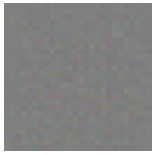

In [10]:
# Comprueba que el generador está funcionando correctamente

# Genera un vector latente aleatorio (ruido)
noise = tf.random.normal([1, LATENT_DIM])

# Genera una imagen utilizando el generador
generated_image = generator(noise, training=False)

# Muestra las dimensiones de la imagen generada
print("Dimensiones de la imagen generada:", generated_image.shape)

# Verifica el rango de valores de la imagen generada
print("Rango de valores de la imagen generada:", generated_image.numpy().min(), "a", generated_image.numpy().max())

# Muestra la imagen generada
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2)  # Convierte el rango de valores a [0, 1]
plt.axis('off')
plt.show()

In [11]:
discriminator = keras.Sequential([
    # Primera capa convolucional
    layers.Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=(28, 28, 3)),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),

    # Segunda capa convolucional
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',  input_shape=(28, 28, 3)),
    layers.LeakyReLU(alpha=0.2),
    layers.Dropout(0.3),

    # Aplana la salida
    layers.Flatten(),
    layers.Dense(1, activation="sigmoid") # Decide si la imagen es real o generada
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [12]:
# Prueba el discriminador con una imagen creada por el generador

# Genera un vector latente aleatorio (ruido)
noise = tf.random.normal([1, LATENT_DIM])

# Genera una imagen utilizando el generador
generated_image = generator(noise, training=False)

# Pasamos la imagen por el discriminador
generated_image = tf.image.resize(generated_image, (28, 28))  # Redimensiona a 28x28
decision = discriminator(generated_image)
print("Decision del discriminador (valor cercano a 0 = falso, 1 = real): ", decision)

Decision del discriminador (valor cercano a 0 = falso, 1 = real):  tf.Tensor([[0.5005832]], shape=(1, 1), dtype=float32)


In [13]:
# Inspecciona un lote del dataset
dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(batch_size)

for batch in dataset.take(1):
  print(f"Tamaño del batch: {batch.shape}")
  break

Tamaño del batch: (32, 28, 28, 1)


In [14]:
# Parámetros del entrenamiento
EPOCHS = 20
# LATENT_DIM = 100
# BATCH_SIZE = 32

In [15]:
# Iniciamos los optimizadores y la función de pérdida
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # No se necesita logits porque la última capa era un sigmoide
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

**Gradientes**: Son vectores que indican la dirección y magnitud en la que deben ajustarse los pesos de un modelo para minimizar la función de pérdida.

Época 1/20
Pérdida del discriminador: 1.4632972478866577, Pérdida del generador: 0.678464949131012
Pérdida del discriminador: 1.436997413635254, Pérdida del generador: 0.640724778175354
Pérdida del discriminador: 1.4671562910079956, Pérdida del generador: 0.6151911020278931
Pérdida del discriminador: 1.4470714330673218, Pérdida del generador: 0.617336630821228
Pérdida del discriminador: 1.4331766366958618, Pérdida del generador: 0.6316884756088257
Pérdida del discriminador: 1.3803473711013794, Pérdida del generador: 0.6584327220916748
Pérdida del discriminador: 1.3174656629562378, Pérdida del generador: 0.6871011853218079
Pérdida del discriminador: 1.2905476093292236, Pérdida del generador: 0.7177732586860657
Pérdida del discriminador: 1.2327115535736084, Pérdida del generador: 0.7481497526168823
Pérdida del discriminador: 1.17127525806427, Pérdida del generador: 0.7710285186767578
Pérdida del discriminador: 1.134817123413086, Pérdida del generador: 0.7700823545455933
Pérdida del discr

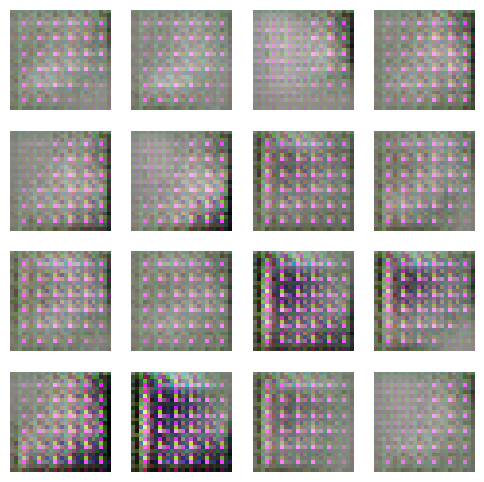

Época 3/20
Pérdida del discriminador: 0.01592688262462616, Pérdida del generador: 4.624541759490967
Pérdida del discriminador: 0.013141683302819729, Pérdida del generador: 4.643939971923828
Pérdida del discriminador: 0.012109419330954552, Pérdida del generador: 4.660693168640137
Pérdida del discriminador: 0.011924141086637974, Pérdida del generador: 4.6204833984375
Pérdida del discriminador: 0.01168916467577219, Pérdida del generador: 4.648183822631836
Pérdida del discriminador: 0.015093732625246048, Pérdida del generador: 4.662006378173828
Pérdida del discriminador: 0.01553133875131607, Pérdida del generador: 4.687457084655762
Pérdida del discriminador: 0.013790439814329147, Pérdida del generador: 4.681509971618652
Pérdida del discriminador: 0.021975938230752945, Pérdida del generador: 4.675319194793701
Pérdida del discriminador: 0.09450996667146683, Pérdida del generador: 4.649933815002441
Pérdida del discriminador: 0.012508734129369259, Pérdida del generador: 4.597783088684082
Pérdi

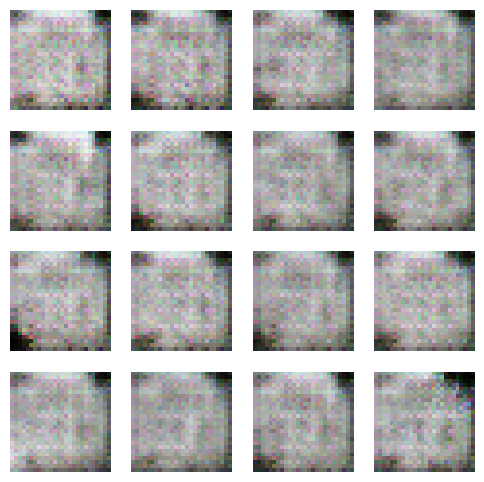

Época 5/20
Pérdida del discriminador: 0.0013120255898684263, Pérdida del generador: 6.787149906158447
Pérdida del discriminador: 0.0012246683472767472, Pérdida del generador: 6.796295166015625
Pérdida del discriminador: 0.0012266647536307573, Pérdida del generador: 6.802500247955322
Pérdida del discriminador: 0.0011290363036096096, Pérdida del generador: 6.829258918762207
Pérdida del discriminador: 0.0011008454021066427, Pérdida del generador: 6.848228454589844
Pérdida del discriminador: 0.0012111347168684006, Pérdida del generador: 6.8736772537231445
Pérdida del discriminador: 0.0012930940138176084, Pérdida del generador: 6.9050469398498535
Pérdida del discriminador: 0.000999990850687027, Pérdida del generador: 6.911368370056152
Pérdida del discriminador: 0.0013557601487264037, Pérdida del generador: 6.923077583312988
Pérdida del discriminador: 0.0024696849286556244, Pérdida del generador: 6.944423198699951
Pérdida del discriminador: 0.0009997010929509997, Pérdida del generador: 6.974

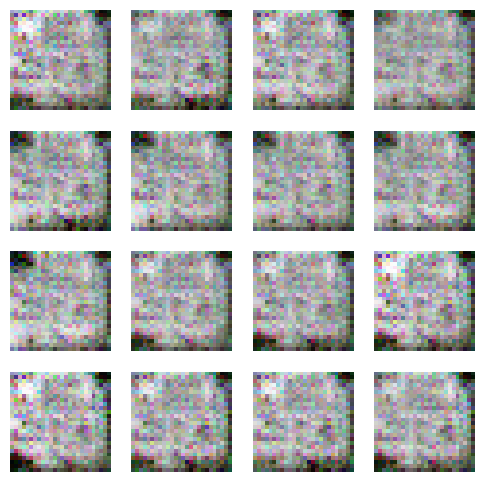

Época 7/20
Pérdida del discriminador: 0.00044277356937527657, Pérdida del generador: 7.809134483337402
Pérdida del discriminador: 0.0004500008944887668, Pérdida del generador: 7.831731796264648
Pérdida del discriminador: 0.0004211168852634728, Pérdida del generador: 7.825692176818848
Pérdida del discriminador: 0.00045360217336565256, Pérdida del generador: 7.83168888092041
Pérdida del discriminador: 0.0004570134624373168, Pérdida del generador: 7.840378761291504
Pérdida del discriminador: 0.0004778605652973056, Pérdida del generador: 7.853839874267578
Pérdida del discriminador: 0.00041609094478189945, Pérdida del generador: 7.8647918701171875
Pérdida del discriminador: 0.0004282861191313714, Pérdida del generador: 7.871218204498291
Pérdida del discriminador: 0.000550666474737227, Pérdida del generador: 7.880168914794922
Pérdida del discriminador: 0.0013246254529803991, Pérdida del generador: 7.875630855560303
Pérdida del discriminador: 0.00034596529440023005, Pérdida del generador: 7.8

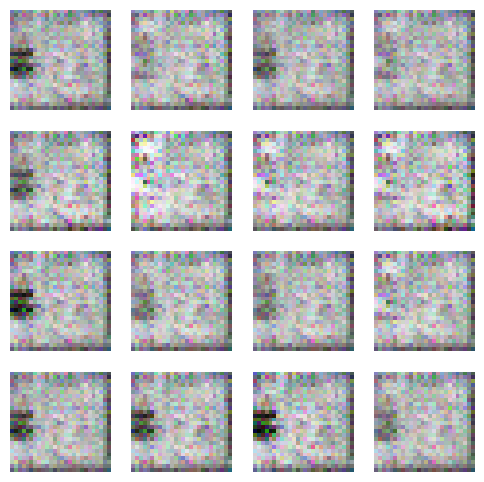

Época 9/20
Pérdida del discriminador: 0.000297422957373783, Pérdida del generador: 8.217628479003906
Pérdida del discriminador: 0.0002854288031812757, Pérdida del generador: 8.231819152832031
Pérdida del discriminador: 0.00027900689747184515, Pérdida del generador: 8.199300765991211
Pérdida del discriminador: 0.0002741500793490559, Pérdida del generador: 8.224103927612305
Pérdida del discriminador: 0.000295101577648893, Pérdida del generador: 8.226003646850586
Pérdida del discriminador: 0.0003035465779248625, Pérdida del generador: 8.248987197875977
Pérdida del discriminador: 0.0003044223121833056, Pérdida del generador: 8.246891021728516
Pérdida del discriminador: 0.0002762886288110167, Pérdida del generador: 8.260697364807129
Pérdida del discriminador: 0.00026522830012254417, Pérdida del generador: 8.279651641845703
Pérdida del discriminador: 0.0003317294467706233, Pérdida del generador: 8.274227142333984
Pérdida del discriminador: 0.00029311099206097424, Pérdida del generador: 8.292

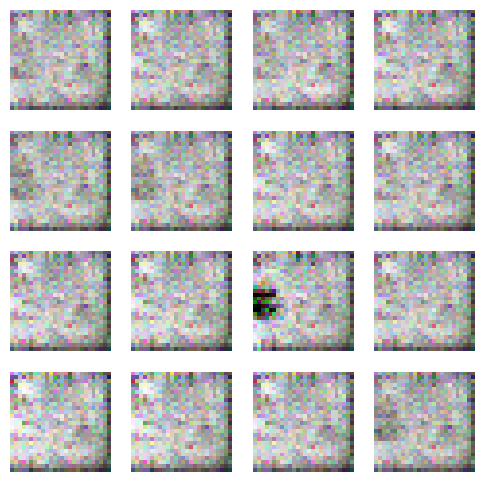

Época 11/20
Pérdida del discriminador: 0.0001602081028977409, Pérdida del generador: 8.879555702209473
Pérdida del discriminador: 0.00015514691767748445, Pérdida del generador: 8.883726119995117
Pérdida del discriminador: 0.0001524583640275523, Pérdida del generador: 8.896631240844727
Pérdida del discriminador: 0.0001469047856517136, Pérdida del generador: 8.923053741455078
Pérdida del discriminador: 0.00017086838488467038, Pérdida del generador: 8.932640075683594
Pérdida del discriminador: 0.0001455144229112193, Pérdida del generador: 8.944231033325195
Pérdida del discriminador: 0.00012739395606331527, Pérdida del generador: 8.945039749145508
Pérdida del discriminador: 0.00015278765931725502, Pérdida del generador: 8.968775749206543
Pérdida del discriminador: 0.00014580291463062167, Pérdida del generador: 8.996797561645508
Pérdida del discriminador: 0.0002157582202926278, Pérdida del generador: 9.013652801513672
Pérdida del discriminador: 0.00013142813986632973, Pérdida del generador:

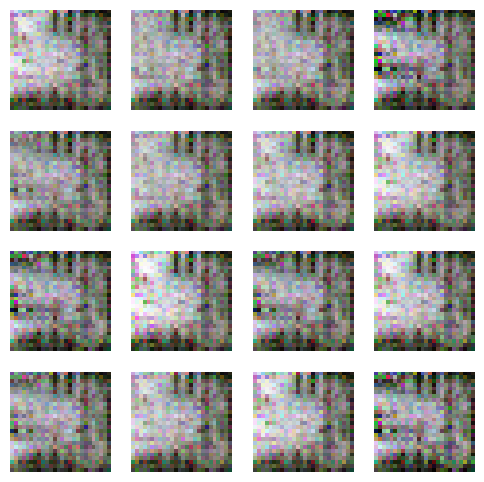

Época 13/20
Pérdida del discriminador: 5.672958286595531e-05, Pérdida del generador: 9.896211624145508
Pérdida del discriminador: 5.358827183954418e-05, Pérdida del generador: 9.929130554199219
Pérdida del discriminador: 5.715619045076892e-05, Pérdida del generador: 9.925056457519531
Pérdida del discriminador: 5.5151249398477376e-05, Pérdida del generador: 9.912899017333984
Pérdida del discriminador: 6.200614006957039e-05, Pérdida del generador: 9.91714096069336
Pérdida del discriminador: 0.0004198942333459854, Pérdida del generador: 9.924174308776855
Pérdida del discriminador: 5.969155245111324e-05, Pérdida del generador: 9.909379959106445
Pérdida del discriminador: 5.859865268575959e-05, Pérdida del generador: 9.903877258300781
Pérdida del discriminador: 5.848893852089532e-05, Pérdida del generador: 9.889887809753418
Pérdida del discriminador: 7.419926987495273e-05, Pérdida del generador: 9.920896530151367
Pérdida del discriminador: 5.6686341849854216e-05, Pérdida del generador: 9.92

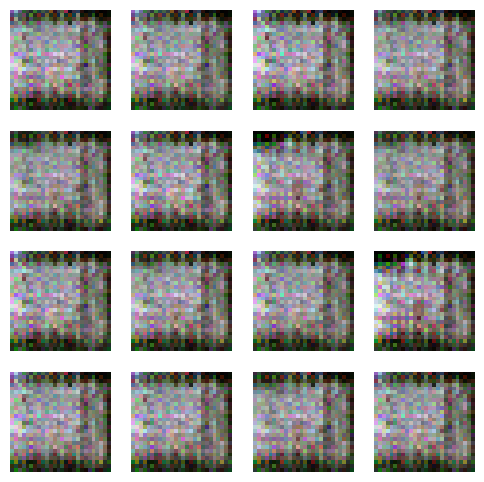

Época 15/20
Pérdida del discriminador: 4.852092752116732e-05, Pérdida del generador: 10.079174041748047
Pérdida del discriminador: 5.224527922109701e-05, Pérdida del generador: 10.07929801940918
Pérdida del discriminador: 5.328647966962308e-05, Pérdida del generador: 10.093021392822266
Pérdida del discriminador: 5.500826955540106e-05, Pérdida del generador: 10.093992233276367
Pérdida del discriminador: 5.4299223847920075e-05, Pérdida del generador: 10.112061500549316
Pérdida del discriminador: 4.854797953157686e-05, Pérdida del generador: 10.118574142456055
Pérdida del discriminador: 4.541777525446378e-05, Pérdida del generador: 10.124975204467773
Pérdida del discriminador: 4.90549391543027e-05, Pérdida del generador: 10.126810073852539
Pérdida del discriminador: 3.687420394271612e-05, Pérdida del generador: 10.144453048706055
Pérdida del discriminador: 0.00010081114305648953, Pérdida del generador: 10.146078109741211
Pérdida del discriminador: 4.3077478039776906e-05, Pérdida del gener

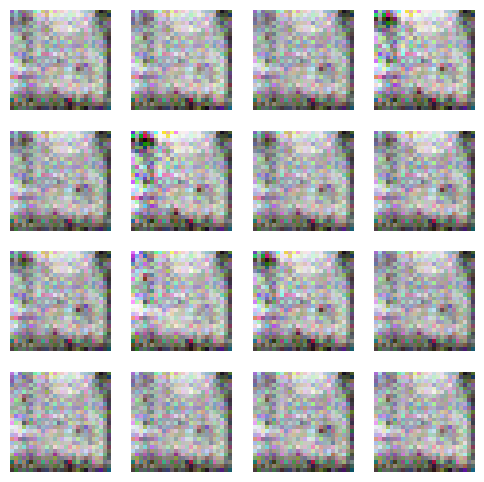

Época 17/20
Pérdida del discriminador: 2.389457768003922e-05, Pérdida del generador: 10.8234281539917
Pérdida del discriminador: 2.067079367407132e-05, Pérdida del generador: 10.826163291931152
Pérdida del discriminador: 2.505090378690511e-05, Pérdida del generador: 10.827773094177246
Pérdida del discriminador: 2.1689409550162964e-05, Pérdida del generador: 10.83076000213623
Pérdida del discriminador: 1.9928957044612616e-05, Pérdida del generador: 10.83545207977295
Pérdida del discriminador: 3.193233715137467e-05, Pérdida del generador: 10.838672637939453
Pérdida del discriminador: 2.1325535271898843e-05, Pérdida del generador: 10.84505844116211
Pérdida del discriminador: 1.930032522068359e-05, Pérdida del generador: 10.848881721496582
Pérdida del discriminador: 2.2242065824684687e-05, Pérdida del generador: 10.855325698852539
Pérdida del discriminador: 7.057646871544421e-05, Pérdida del generador: 10.853986740112305
Pérdida del discriminador: 2.003539884753991e-05, Pérdida del generad

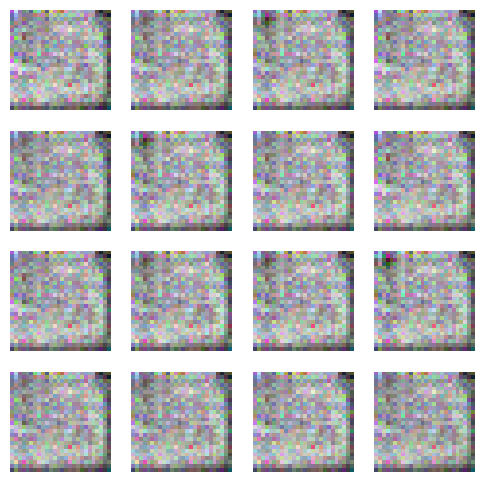

Época 19/20
Pérdida del discriminador: 1.4429065231524874e-05, Pérdida del generador: 11.246665954589844
Pérdida del discriminador: 1.4209778782969806e-05, Pérdida del generador: 11.243463516235352
Pérdida del discriminador: 1.366702144878218e-05, Pérdida del generador: 11.242717742919922
Pérdida del discriminador: 1.3737887456954923e-05, Pérdida del generador: 11.251733779907227
Pérdida del discriminador: 1.424848051101435e-05, Pérdida del generador: 11.25673770904541
Pérdida del discriminador: 1.615410110389348e-05, Pérdida del generador: 11.260683059692383
Pérdida del discriminador: 1.4803512385697104e-05, Pérdida del generador: 11.267269134521484
Pérdida del discriminador: 1.4572048712579999e-05, Pérdida del generador: 11.265862464904785
Pérdida del discriminador: 1.3717488400288858e-05, Pérdida del generador: 11.267610549926758
Pérdida del discriminador: 2.0509471141849644e-05, Pérdida del generador: 11.286309242248535
Pérdida del discriminador: 1.4775785530218855e-05, Pérdida del

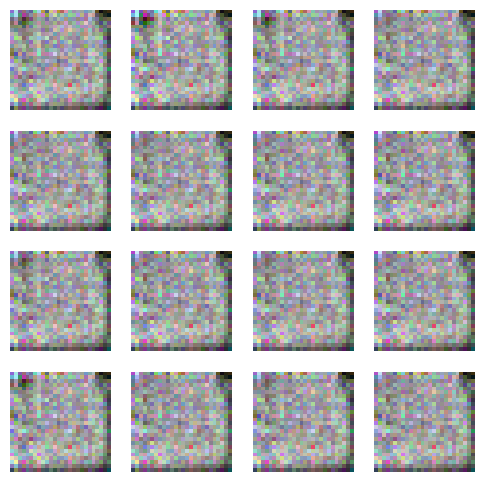

In [16]:
# Entrenamiento de la GAN
for epoch in range(EPOCHS):
    print(f"Época {epoch + 1}/{EPOCHS}")

    for real_images in dataset:
        # Obtiene el tamaño del lote actual
        current_batch_size = real_images.shape[0]

        # Genera ruido aleatorio para crear imágenes falsas
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Crea imágenes falsas con el generador
        generated_images = generator(noise, training=True)

        # Etiquetas realies y falsas
        real_labels = tf.ones((current_batch_size, 1)) # Imágenes reales (etiqueta = 1)
        fake_labels = tf.zeros((current_batch_size, 1)) # Imágenes generadas (etiqueta = 0)

        # Entrena el discriminador
        with tf.GradientTape() as disc_tape: # Crea un contexto de gradiente para calcular la pérdida del discriminador.
            # Obtiene las predicciones del discriminador para las imágenes reales.
            real_images = tf.image.grayscale_to_rgb(real_images)  # Convierte de (28,28,1) a (28,28,3)
            real_output = discriminator(real_images, training=True)
            # Obtiene las predicciones del discriminador para las imágenes falsas/generadas.
            fake_output = discriminator(generated_images, training=True)
            # Calcula la pérdida del discriminador para las imágenes reales.
            disc_loss_real = cross_entropy(real_labels, real_output)
            # Calcula la pérdida del discriminador para las imágenes generadas (fake).
            disc_loss_fake = cross_entropy(fake_labels, fake_output)
            # Suma ambas pérdidas para obtener la pérdida todal del discriminador.
            disc_loss = disc_loss_real + disc_loss_fake

        # Calcula los gradientes de la pérdida con respecto a las variables entrenables del discriminador
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del discriminador.
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # Genera ruido nuevamente para entrenar el generador
        noise = tf.random.normal([current_batch_size, LATENT_DIM])

        # Entrena el generador
        with tf.GradientTape() as gen_tape: # Crea un contexto de gradiente para calcular la pérdida del generador.
            # Crea imágenes falsas con el generador
            generated_images = generator(noise, training=True)
            # Evalúa las imágenes generadas con el discriminador (sin actualizar los pesos).
            fake_output = discriminator(generated_images, training=False)
            # Calcula la pérdida del generador intentando "engañar" al discriminador.
            gen_loss = cross_entropy(real_labels, fake_output)

        # Calcula los gradientes de la pérdida con respecto a las variables entrenables del generador.
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        # Aplica los gradientes para actualizar los pesos del generador.
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        # Muestra la pérdida de cada red neuronal
        print(f"Pérdida del discriminador: {disc_loss.numpy()}, Pérdida del generador: {gen_loss.numpy()}")

    # Muestra el progreso cada 2 épocas
    if (epoch + 1) % 2 == 0 or epoch == EPOCHS - 1:
        # Genera y muestra imágenes de ejemplo
        noise = tf.random.normal([16, LATENT_DIM])
        generated_images = generator(noise, training=False)
        generated_images = (generated_images + 1) / 2 # Reescala de [-1, 1] a [0, 1]

        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        for img, ax in zip(generated_images, axes.flatten()):
            ax.imshow(img)
            ax.axis("off")
        plt.show()